In [161]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn.functional as F
from tqdm import tqdm
from MIOFlow.models import GrowthRateModel

In [163]:
# df = pd.read_csv("../../MIOFlow_growth_rate/data/data_dropped.csv")
# df0 = pd.read_csv("../data/mioflow_balanced_subsampled_growth.csv", index_col=0)
df0 = pd.read_csv("../data/mioflow_balanced_subsampled4.csv", index_col=0)
df = pd.read_csv("../data/mioflow_balanced_subsampled_grown4.csv", index_col=0)
scaler = StandardScaler()
df[['d1', 'd2']] = scaler.fit_transform(df[['d1', 'd2']])
df0[['d1', 'd2']] = scaler.transform(df0[['d1', 'd2']])
growth = pd.read_csv("../data/growth_rate4.csv", index_col=0)

In [164]:
df0['growth'] = growth['growth']

In [165]:
def kernel_smooth(x, y, x_eval, bandwidth=1.0):
    """
    Perform kernel smoothing of y based on x using KernelReg from statsmodels
    
    Args:
        x: Input points, array of shape (N, n_features)
        y: Target values, array of shape (N,)
        x_eval: Points to evaluate smoothed function at, array of shape (M, n_features)
        bandwidth: Kernel bandwidth parameter
        
    Returns:
        y_smooth: Smoothed values at x_eval points, array of shape (M,)
    """
    from statsmodels.nonparametric.kernel_regression import KernelReg
    
    # Convert inputs to numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    x_eval = np.asarray(x_eval)
    
    # Fit kernel regression
    kr = KernelReg(endog=y, exog=x, var_type='c'*x.shape[1], bw=[bandwidth]*x.shape[1])
    
    # Predict at evaluation points
    y_smooth, _ = kr.fit(x_eval)
    
    return y_smooth

y_smooth = kernel_smooth(df0.loc[df0['samples']!=3, ['d1', 'd2']], df0.loc[df0['samples']!=3, 'growth'], df0.loc[df0['samples']!=3, ['d1', 'd2']])
# y_smooth = df0.loc[df0['samples']!=3, 'growth']

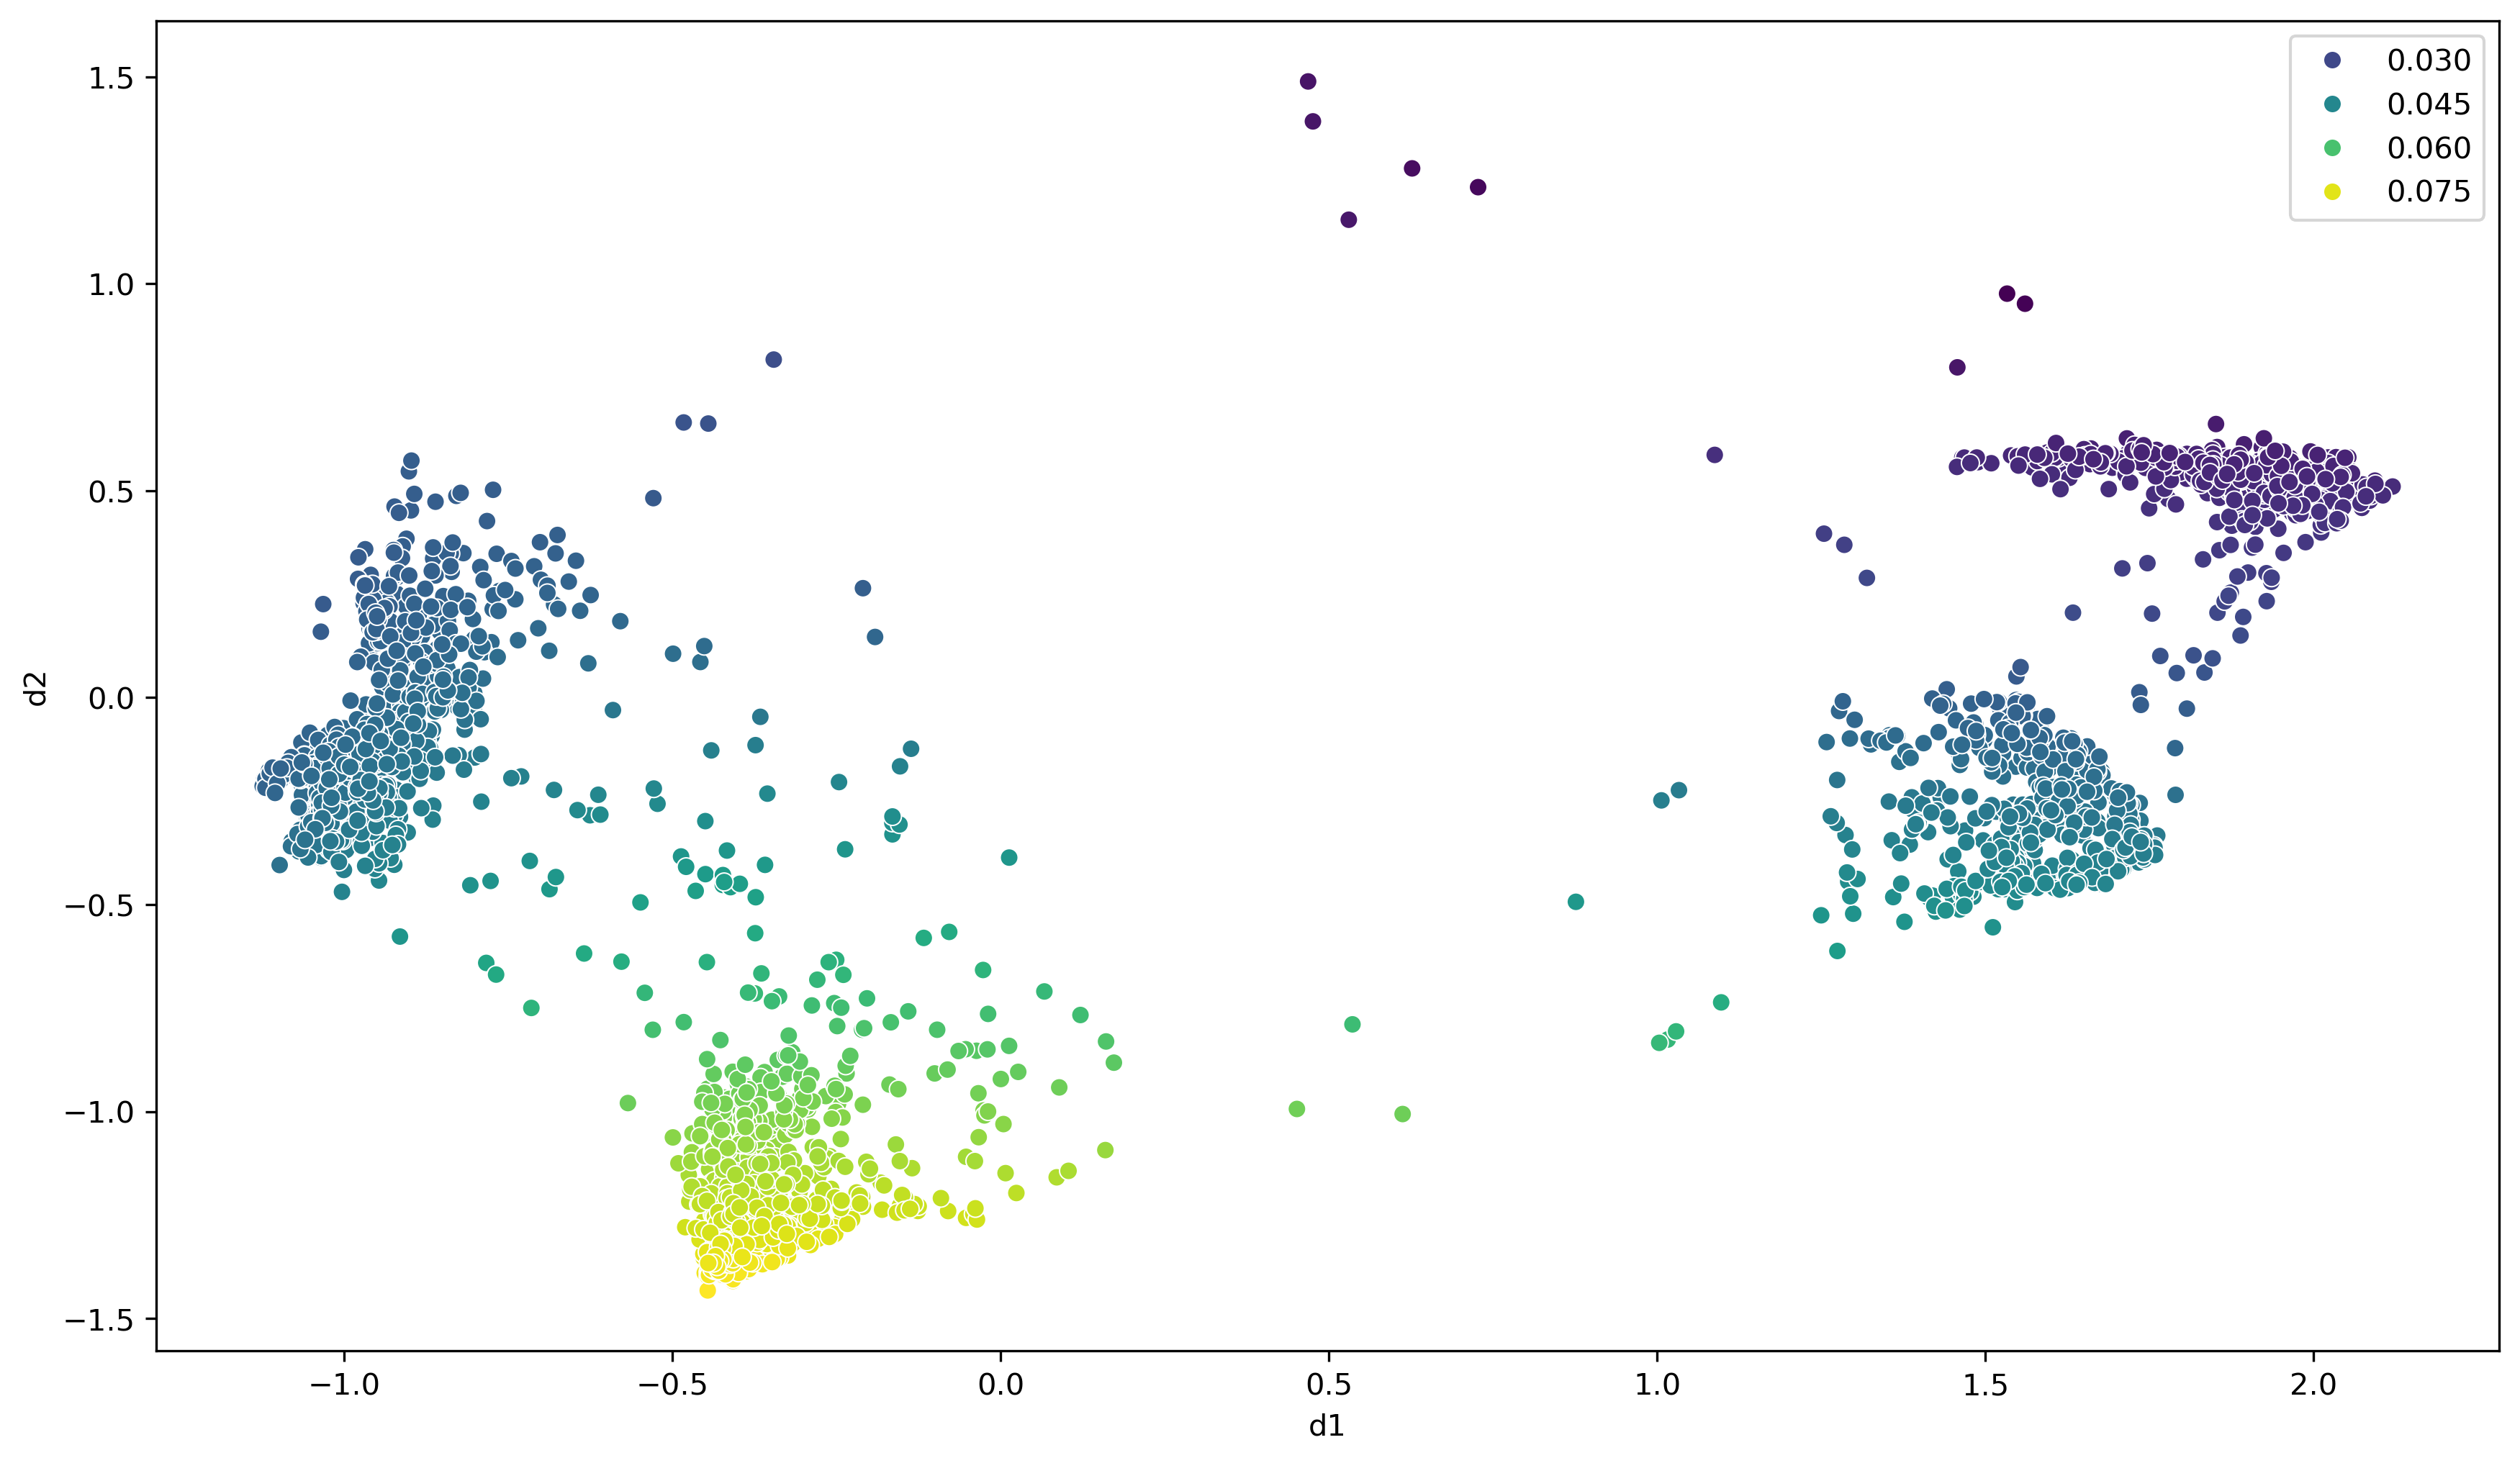

In [166]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(x=df0.loc[df0['samples']!=3, 'd1'], y=df0.loc[df0['samples']!=3, 'd2'], hue=y_smooth, palette='viridis');

In [167]:
df1 = df0.copy()
df1['growth'] = np.nan
df1.loc[df1['samples']!=3, 'growth'] = y_smooth

In [168]:
df1.to_csv("../data/growth_rate_smoothed4.csv")

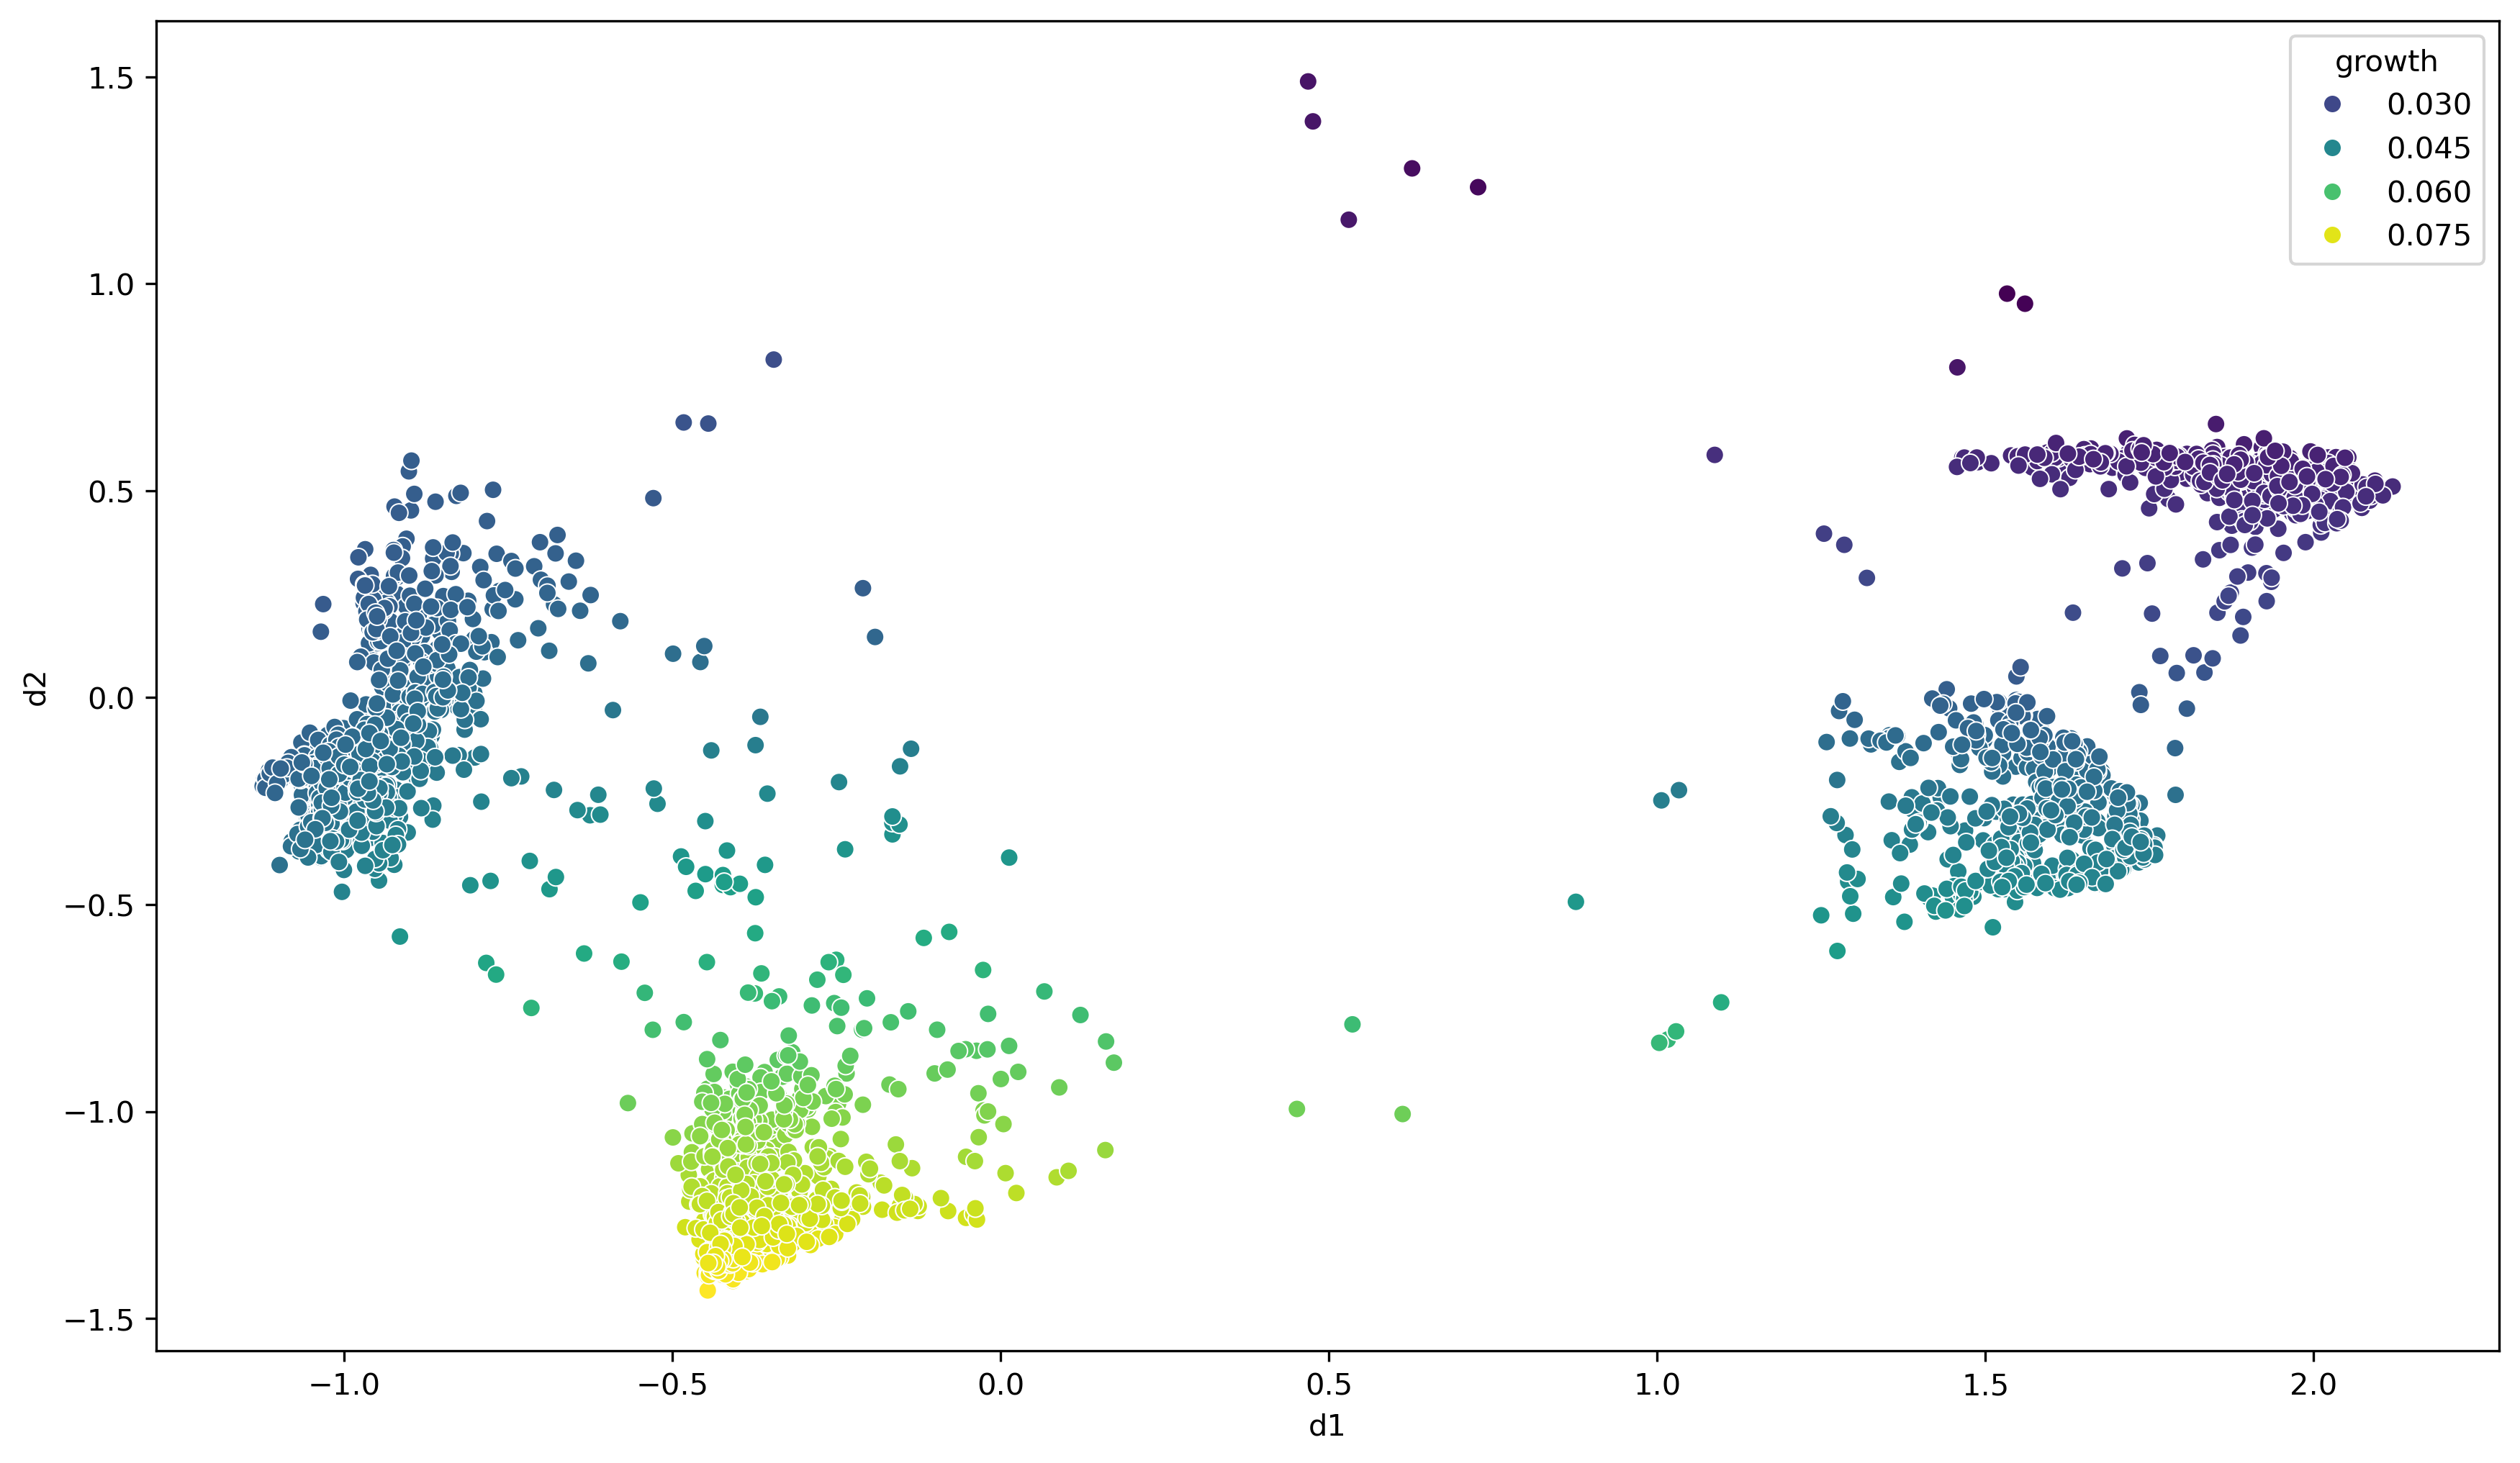

In [169]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df1, x='d1', y='d2', hue='growth', palette='viridis');

Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.27it/s, loss=0.0000]


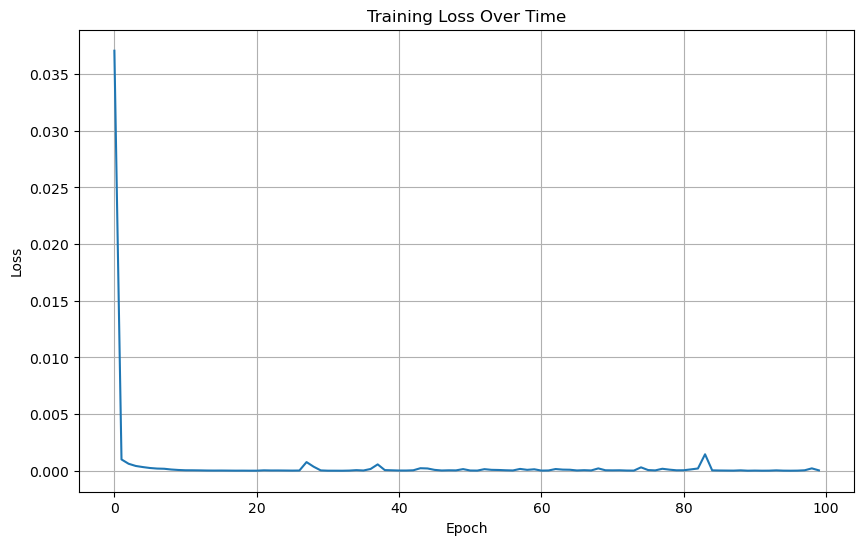

In [170]:
feature_dims = 2
condition_dims = 0
layers = [64, 32]
gmodel = GrowthRateModel(feature_dims, condition_dims, layers, use_time=False)
# train gmodel with sgd
data_x = torch.tensor(df1.loc[df1['samples']!=3, ['d1', 'd2']].values, dtype=torch.float32)
ys = df1.loc[df1['samples']!=3, 'growth'].values
gscaler = MinMaxScaler(feature_range=(0, 2))
ys = gscaler.fit_transform(ys[:, np.newaxis])
data_y = torch.tensor(ys, dtype=torch.float32)
# optimizer = torch.optim.AdamW(gmodel.parameters(), lr=0.01, weight_decay=1e-2)  # Add weight_decay parameter
optimizer = torch.optim.AdamW(gmodel.parameters(), lr=0.01)  # Add weight_decay parameter

# Create data loader
batch_size = 32
dataset = torch.utils.data.TensorDataset(data_x, data_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# List to store losses
losses = []

progress_bar = tqdm(range(100), desc='Epochs', position=0)
for epoch in progress_bar:
    epoch_loss = 0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        pred = gmodel(batch_x)
        loss = F.mse_loss(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

<Figure size 4200x2400 with 0 Axes>

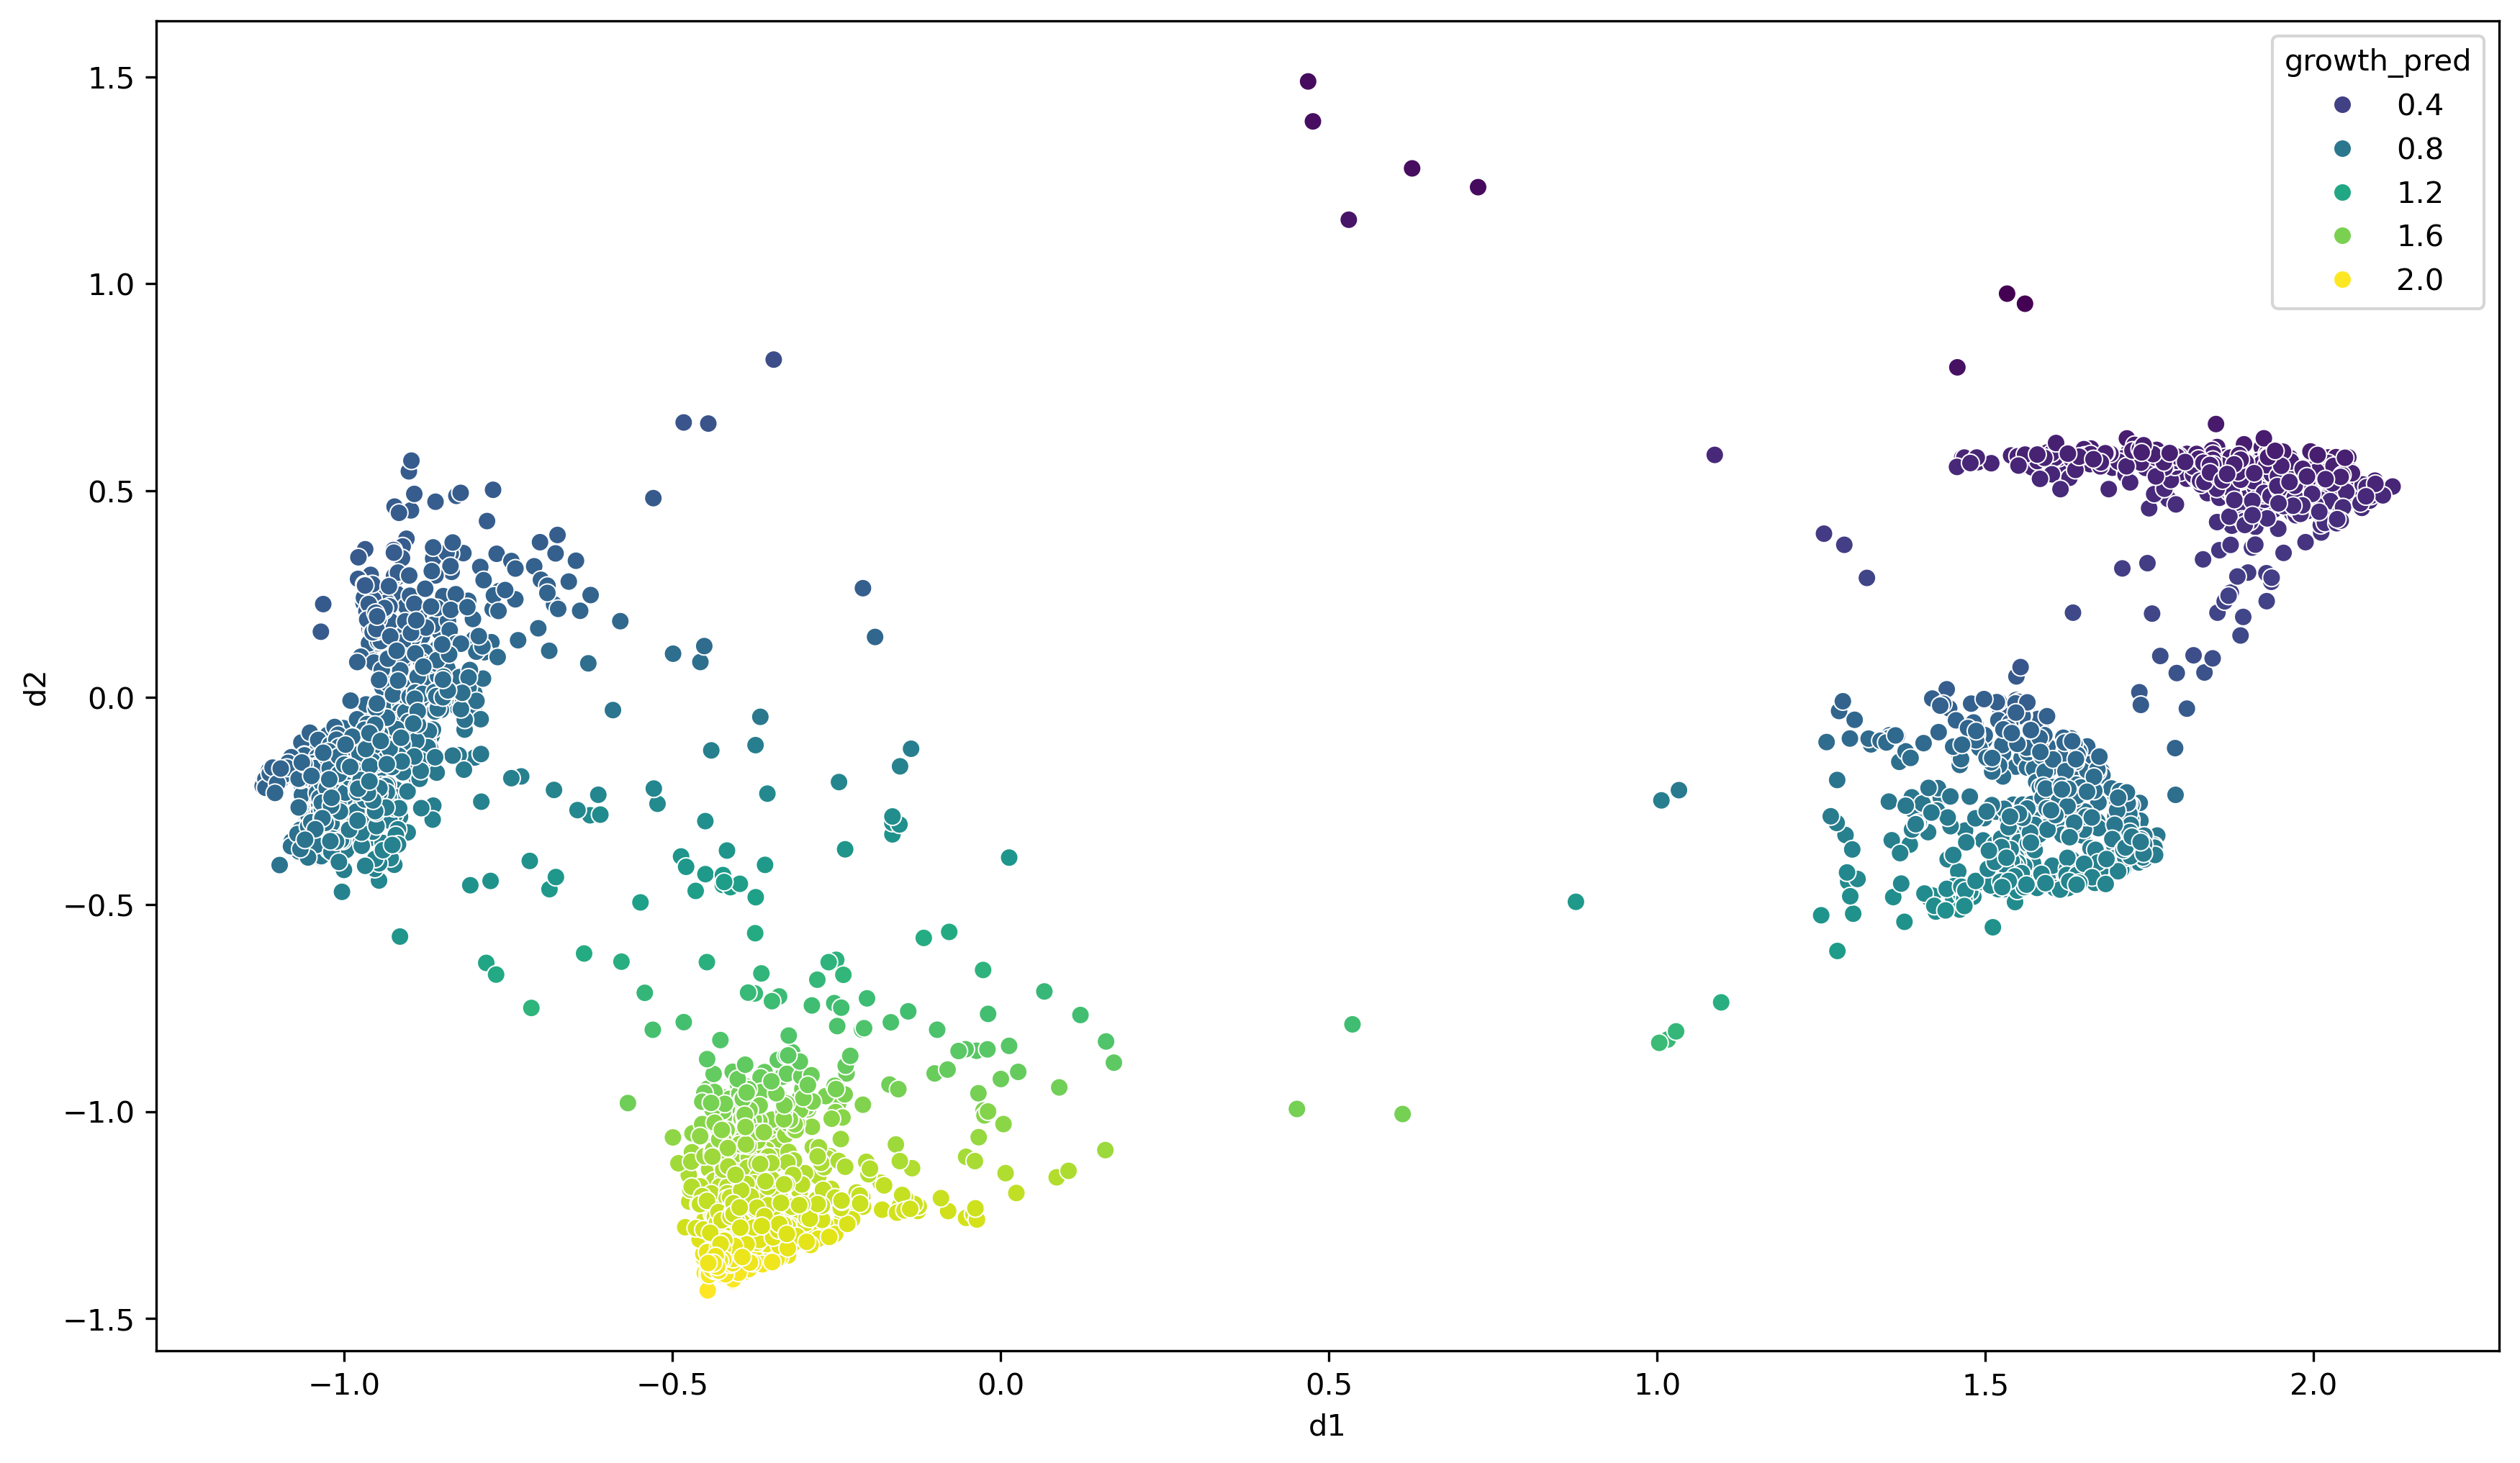

In [171]:
y_pred = gmodel(data_x).flatten().detach().numpy()
fig = plt.figure(figsize=(14, 8), dpi=300)
df2 = df1.copy()
df2['growth_pred'] = np.nan
df2.loc[df2['samples']!=3, 'growth_pred'] = y_pred
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df2, x='d1', y='d2', hue='growth_pred', palette='viridis');


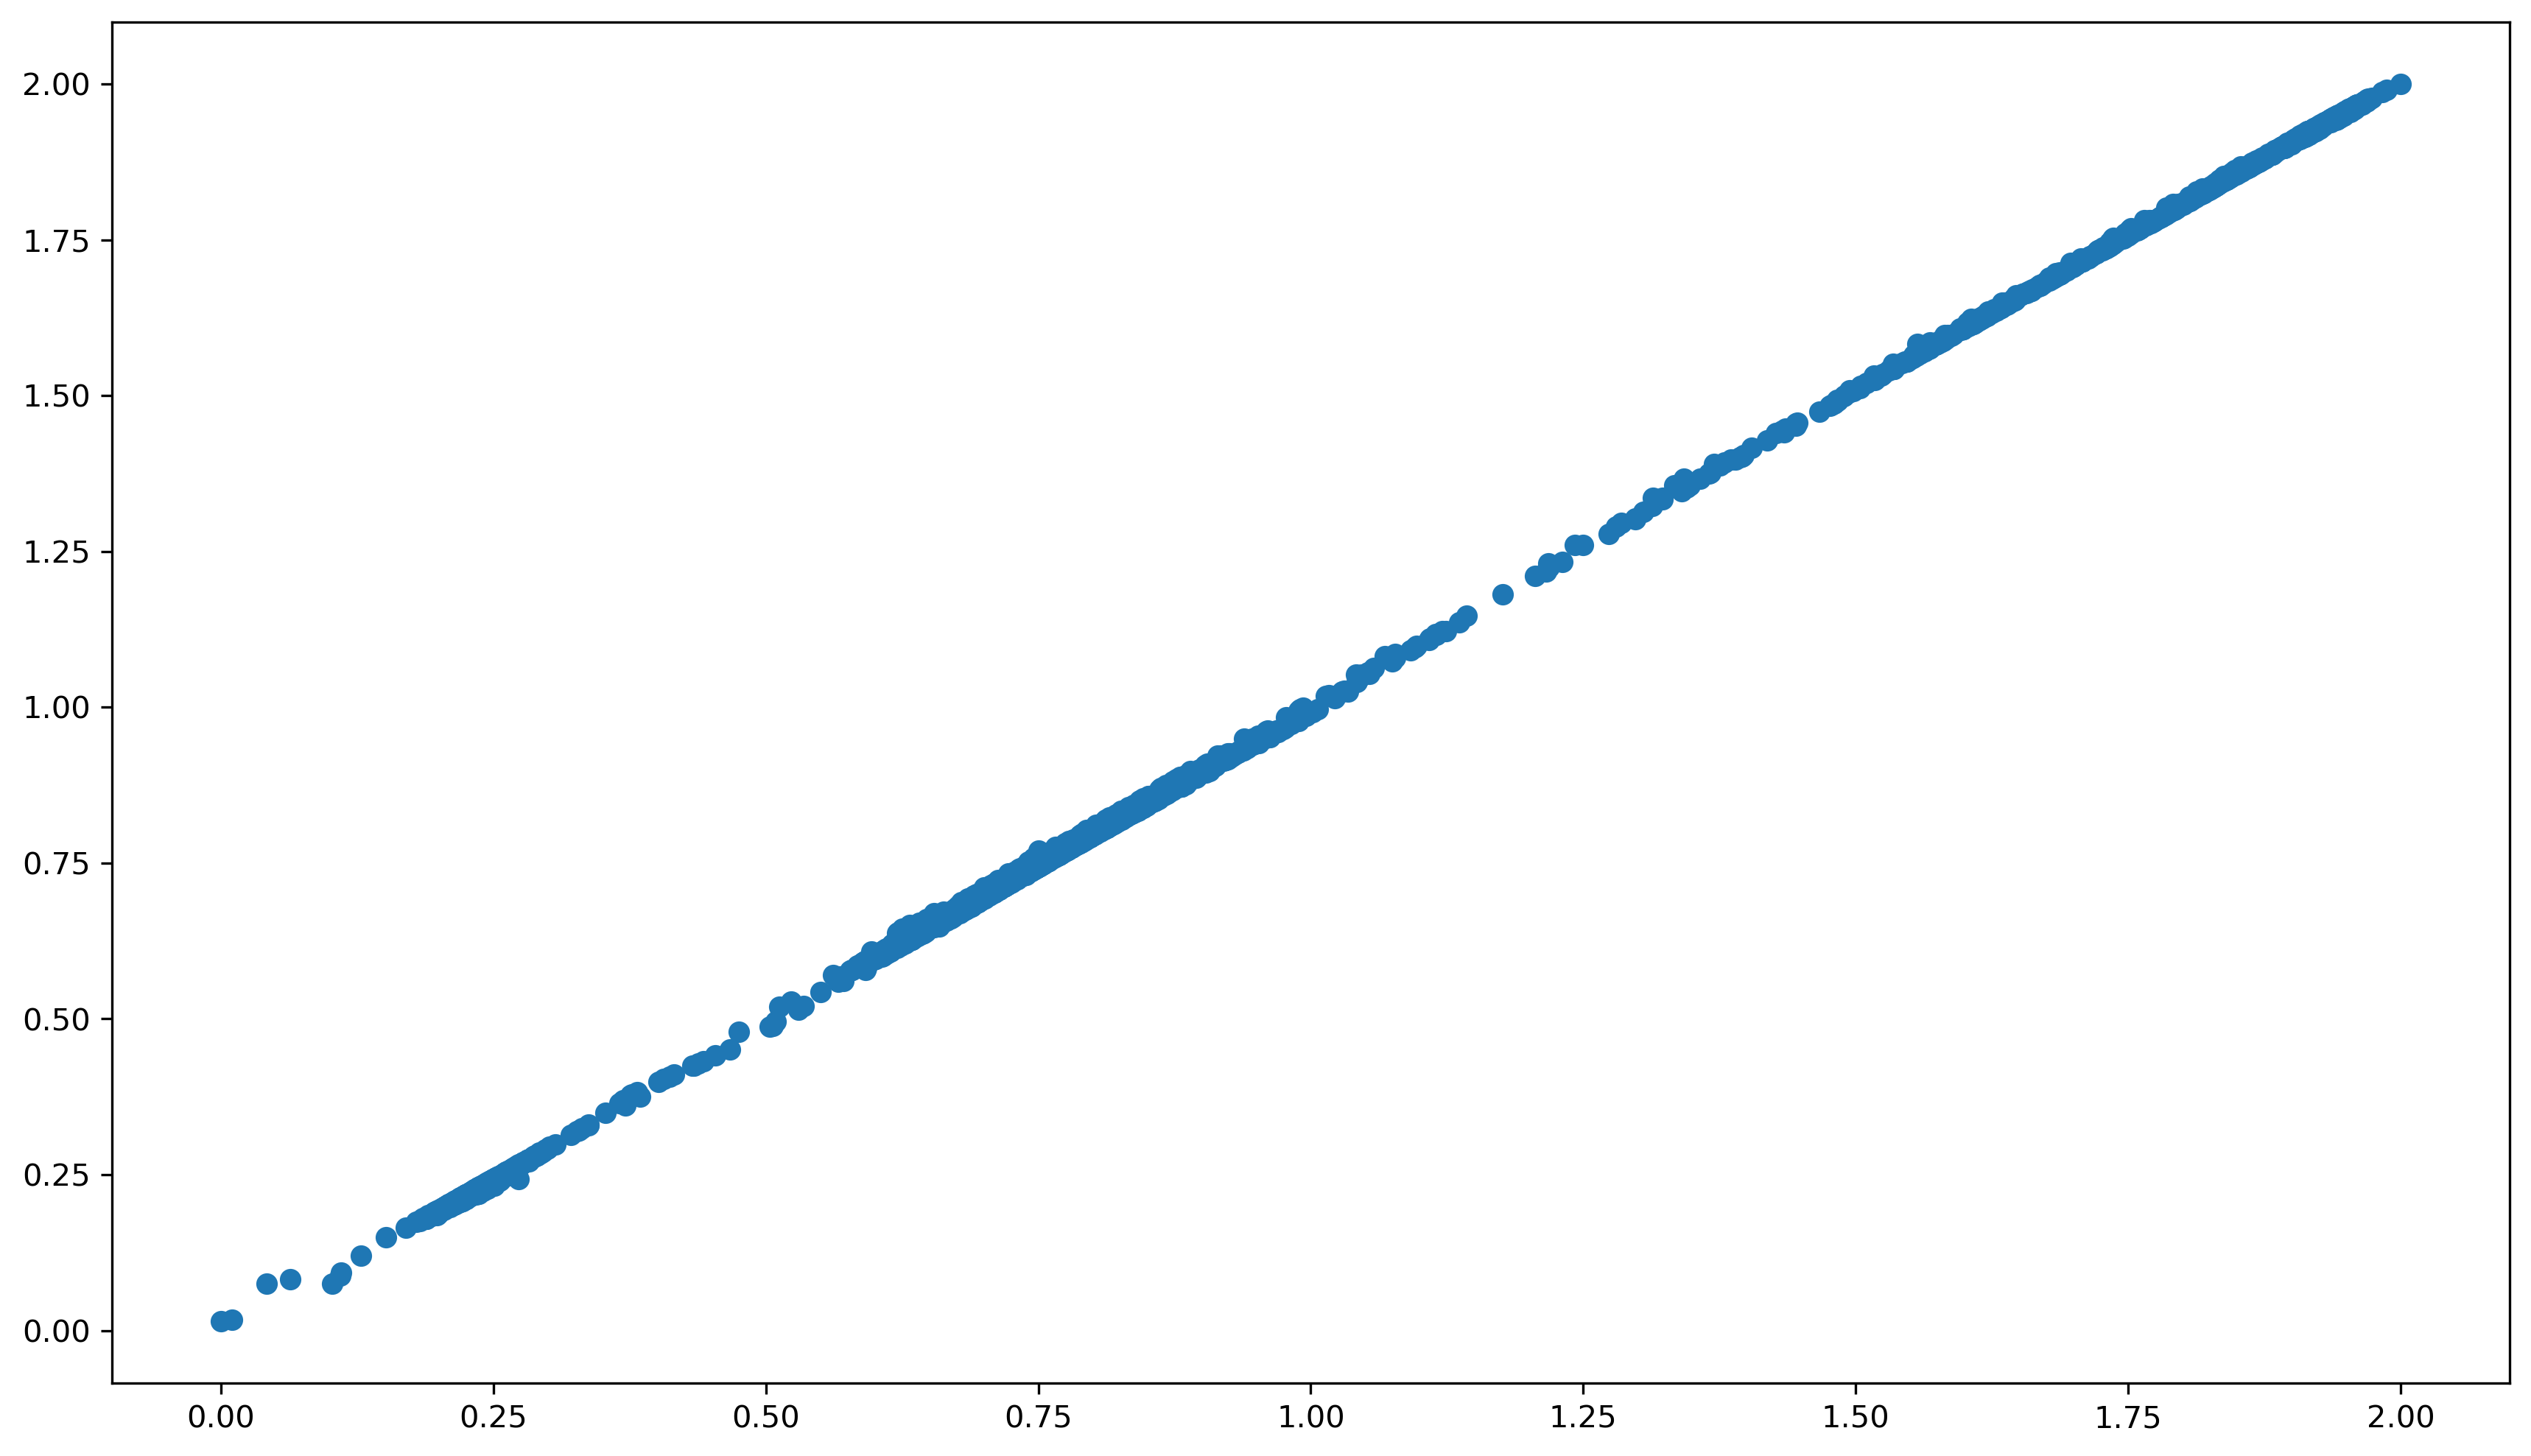

In [172]:
fig = plt.figure(figsize=(14, 8), dpi=300)
plt.scatter(data_y, y_pred);

In [173]:
# Save the trained model
torch.save(gmodel, 'gmodel_full4.pt')  # Save complete model
torch.save(gmodel.state_dict(), 'gmodel_state4.pt')  # Save model state dict

In [174]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0, 2))
df1['growth'] = minmaxscaler.fit_transform(df1[['growth']])

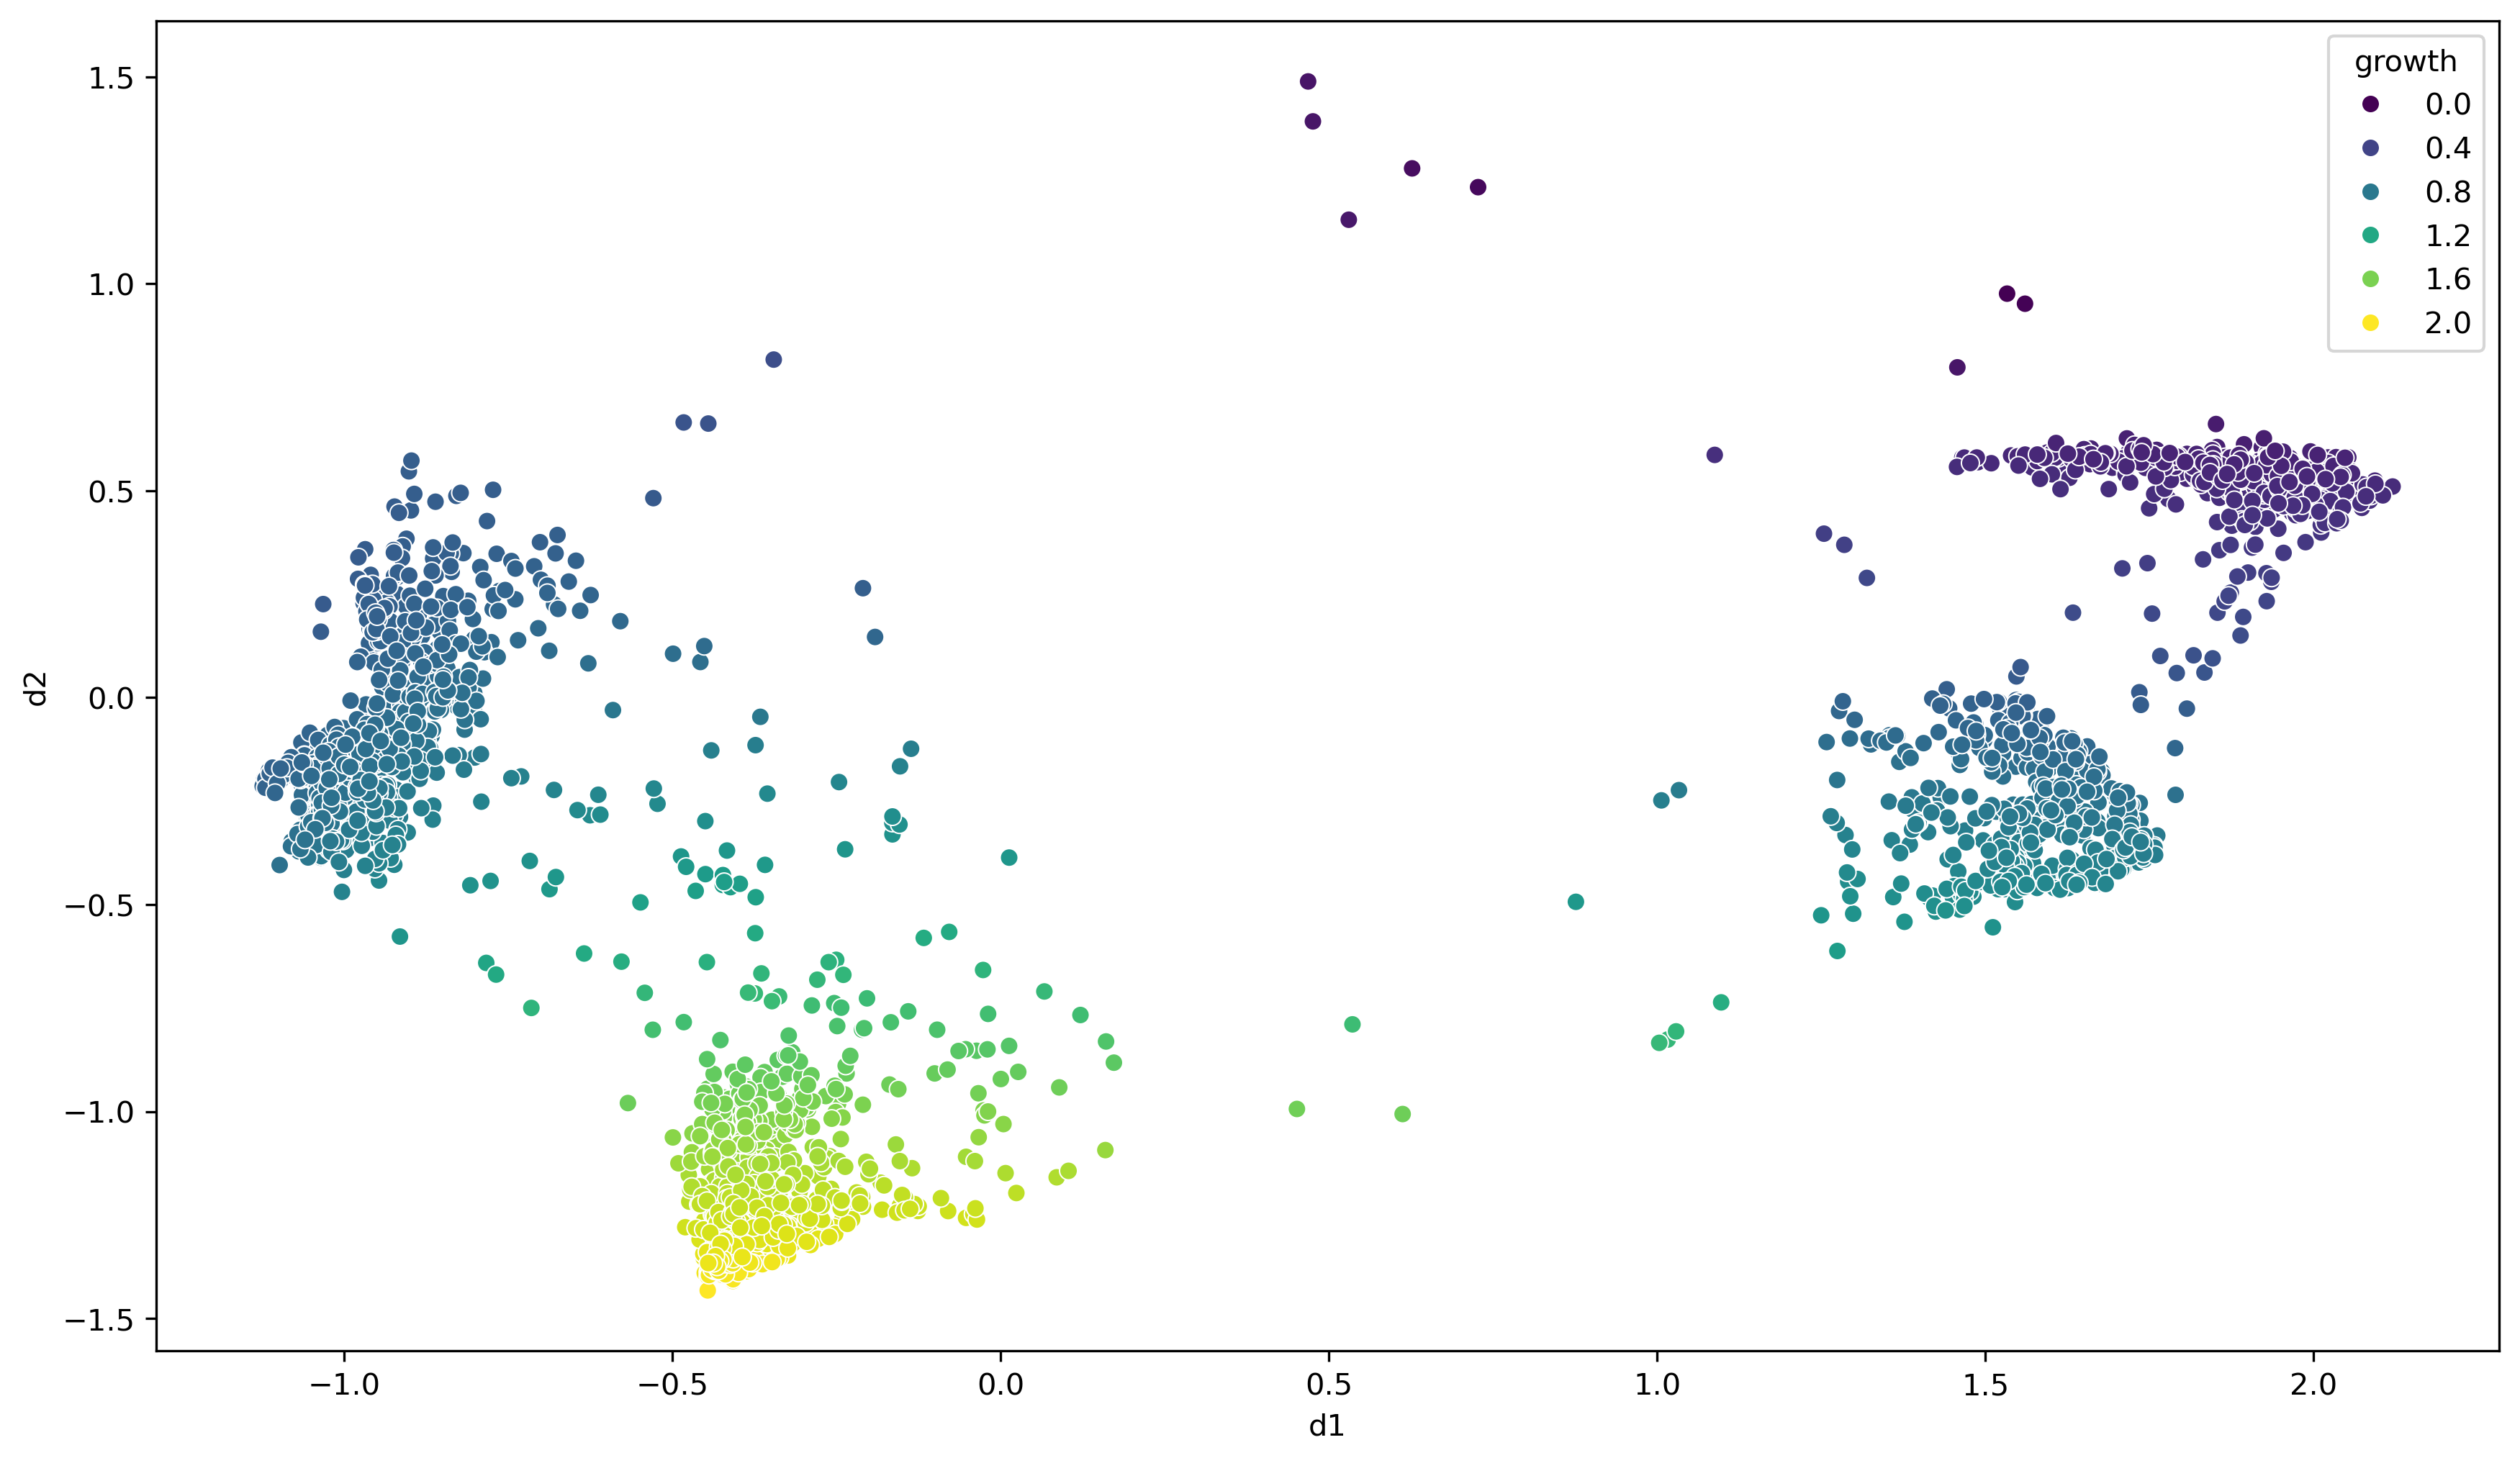

In [175]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df1, x='d1', y='d2', hue='growth', palette='viridis');

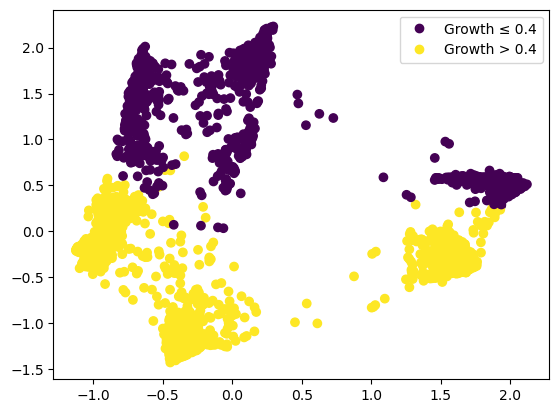

In [176]:
threshold = 0.4
scatter = plt.scatter(df1['d1'], df1['d2'], c=df1['growth']>threshold)
plt.legend(scatter.legend_elements()[0], [f'Growth ≤ {threshold}', f'Growth > {threshold}'])


In [177]:
df1.to_csv("../data/growth_rate_smoothed_rescaled4.csv")

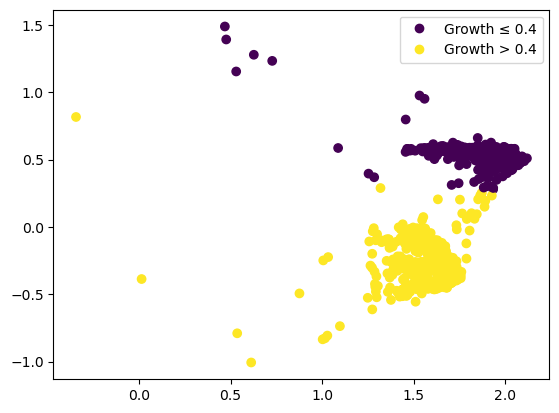

In [178]:
threshold = 0.4
scatter = plt.scatter(df1[df1['samples'] == 0]['d1'], df1[df1['samples'] == 0]['d2'], c=df1[df1['samples'] == 0]['growth']>threshold, alpha=1)
plt.legend(scatter.legend_elements()[0], [f'Growth ≤ {threshold}', f'Growth > {threshold}'])


<Axes: >

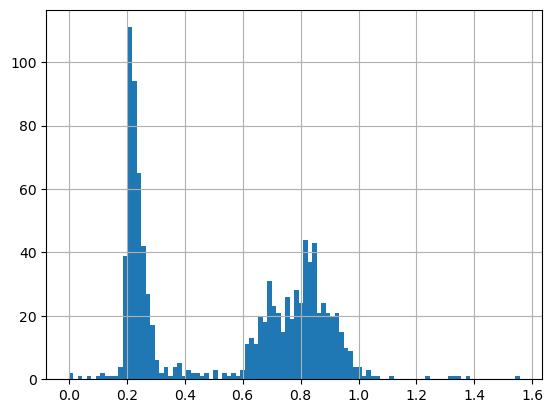

In [179]:
df1[df1['samples'] == 0]['growth'].hist(bins=100)

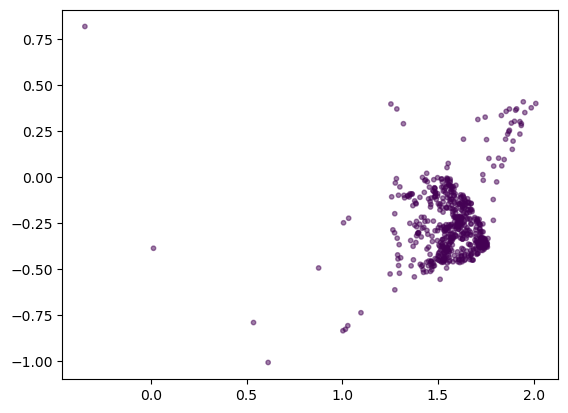

In [180]:
threshold = 0.3
scatter = plt.scatter(df1[(df1['samples'] == 0) & (df1['growth'] > threshold)]['d1'], df1[(df1['samples'] == 0) & (df1['growth'] > threshold)]['d2'], c=df1[(df1['samples'] == 0) & (df1['growth'] > threshold)]['growth']>threshold, s=10, alpha=0.5)
